# Damage Size Regression on Real-world Data Data - Baseline
In this notebook, we conduct experiments to be able to compare to a baseline. Just to make sure, we repeat the experiment several times to make sure that the previously established cross-validation setup gives reliable results also with this approach.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/mixed_regression_AA_BASE.ipynb)

In [1]:
%load_ext rich
%load_ext autoreload
%autoreload 2
%matplotlib inline

from rich import print

random_state = 42

## Prerequisites

In [2]:
import sys
import os
from pathlib import Path
import pandas as pd

# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    %pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    %pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [3]:
# Intel(R) Extension for Scikit-learn for speed-up
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
import time
import glob
import sklearn
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

#...and download raw data if not already downloaded
from data_utils import init_data
init_data(syn_data_path=SYN_DATA_PATH, real_data_path=REAL_DATA_PATH)

from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_cv_indices,
    plot_embedding_targets,
    init_plotting,
    plot_classwise_dist,
    plot_classwise_kde,
)

# configure fonts, etc...
init_plotting()

from scoring_utils import (
    get_real_regression_scoring,
    SHM_Scoring)
from cv_utils import (
    AnomalyShuffleSplit,
    RepeatedAnomalyShuffleSplit,
    CreateAnomalyData,
    dump_cv)
from bench_utils import (
    classification_benchmark,
    repeat_experiment,
    extract_metrics)
from data_utils import (load_reg_data_base,
                        load_syn_reg_data,
                        FEATURE_LIST)
from shm_experiments import conduct_aa_mixed_reg_experiment

time passed: 8.53 s
downloading synthetic data successful: True
time passed: 1.91 s
downloading real world data successful: True


In [5]:
result_file = "20_mixed_regression_AA_dssize.pkl"
result_file = Path(RESULT_PATH, result_file)

## Data Loading

### Synthetic Data

In [6]:
# Xsyn, ysyn = load_reg_data_base(data_path=SYN_DATA_PATH,
#                                 min_radius = 1.9,
#                                 cache=True)

Xsyn, ysyn = load_syn_reg_data(data_path=SYN_DATA_PATH,
                               min_radius = 1.9,
                               cache=True)

In [7]:
Xsyn.shape

(28302, 31)

In [8]:
label_mapping = {
    "0.0": 0.0,
    "2.2": 2.5,
    "2.5": 2.5,
    "2.8": 2.5,
    "3.1": 3.5,
    "3.4": 3.5,
    "3.8": 3.5,
    "4.1": 4.5,
    "4.4": 4.5,
    "4.7": 4.5,
    "5.0": 5.5,
    "6.7": 7.0,
    "8.3": 8.0,
    "10.0": 10.0,
    "12.0": 12.0,
    "14.0": 14.0,
    "16.0": 16.0,
    "18.0": 19.0,
    "20.0": 21.0,
    "22.0": 23.0,
    "24.0": 25.0,
    "26.0": 27.0,
    "28.0": 29.0,
    "30.0": 31.0,
    "32.0": 33.0,
    "34.0": 35.0,
    "36.0": 37.0,
    "38.0": 39.0,
    "40.0": 40.0,
}

# ysyn = np.array([label_mapping[str(y)] for y in ysyn])

In [9]:
ctr = Counter(ysyn)
ctr


Counter({
    0.0: 990,
    2.2: 979,
    2.5: 979,
    2.8: 978,
    3.1: 986,
    3.4: 972,
    3.8: 973,
    4.1: 976,
    4.4: 979,
    4.7: 976,
    5.0: 977,
    6.7: 981,
    8.3: 972,
    10.0: 973,
    12.0: 969,
    14.0: 978,
    16.0: 980,
    18.0: 976,
    20.0: 974,
    22.0: 975,
    24.0: 980,
    26.0: 973,
    28.0: 983,
    30.0: 977,
    32.0: 967,
    34.0: 971,
    36.0: 976,
    38.0: 964,
    40.0: 968
})

### Real World Data

In [10]:
Xreal, yreal = load_syn_reg_data(data_path=REAL_DATA_PATH,
                                 min_radius = 1.,
                                 synthetic=False,
                                 calibration_file=CALIBRATION_FILE)

In [11]:
Xreal.shape

(225, 31)

In [12]:
ctr = Counter(yreal)
ctr


Counter({
    0.0: 9,
    1.5: 9,
    10.0: 9,
    12.0: 9,
    14.0: 9,
    16.0: 9,
    17.0: 9,
    19.0: 9,
    2.5: 9,
    21.0: 9,
    23.0: 9,
    25.0: 9,
    27.0: 9,
    29.0: 9,
    3.5: 9,
    31.0: 9,
    33.0: 9,
    35.0: 9,
    37.0: 9,
    39.0: 9,
    4.5: 9,
    40.0: 9,
    5.5: 9,
    7.0: 9,
    8.0: 9
})

## A-A Experiments

In [13]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from imblearn.under_sampling import ClusterCentroids

from pipe_utils import build_sampled_pipeline

In [14]:
samples_per_class = 40
classes, counts = np.unique(ysyn, return_counts=True)
n_classes = len(classes)

strgy = dict(zip(range(n_classes), [samples_per_class] * n_classes))
sampler = ClusterCentroids(estimator=KMeans(n_init="auto", random_state=random_state), sampling_strategy=strgy, random_state=random_state)

estimator = KNeighborsRegressor(n_neighbors=1, leaf_size=1)

pipeline = build_sampled_pipeline(sampler, estimator)

In [15]:
scoring = get_real_regression_scoring()

results = conduct_aa_mixed_reg_experiment(Xsyn=Xsyn, ysyn=ysyn,
                                          Xreal=Xreal, yreal=yreal,
                                          estimator=pipeline,
                                          name="BASE",
                                          n_repeats=5,
                                          n_splits=32,
                                          test_size=0.1,
                                          scoring=scoring,
                                          random_state=random_state)

## Store results for later

In [16]:
results.to_pickle(result_file)

## Plot some results for overview

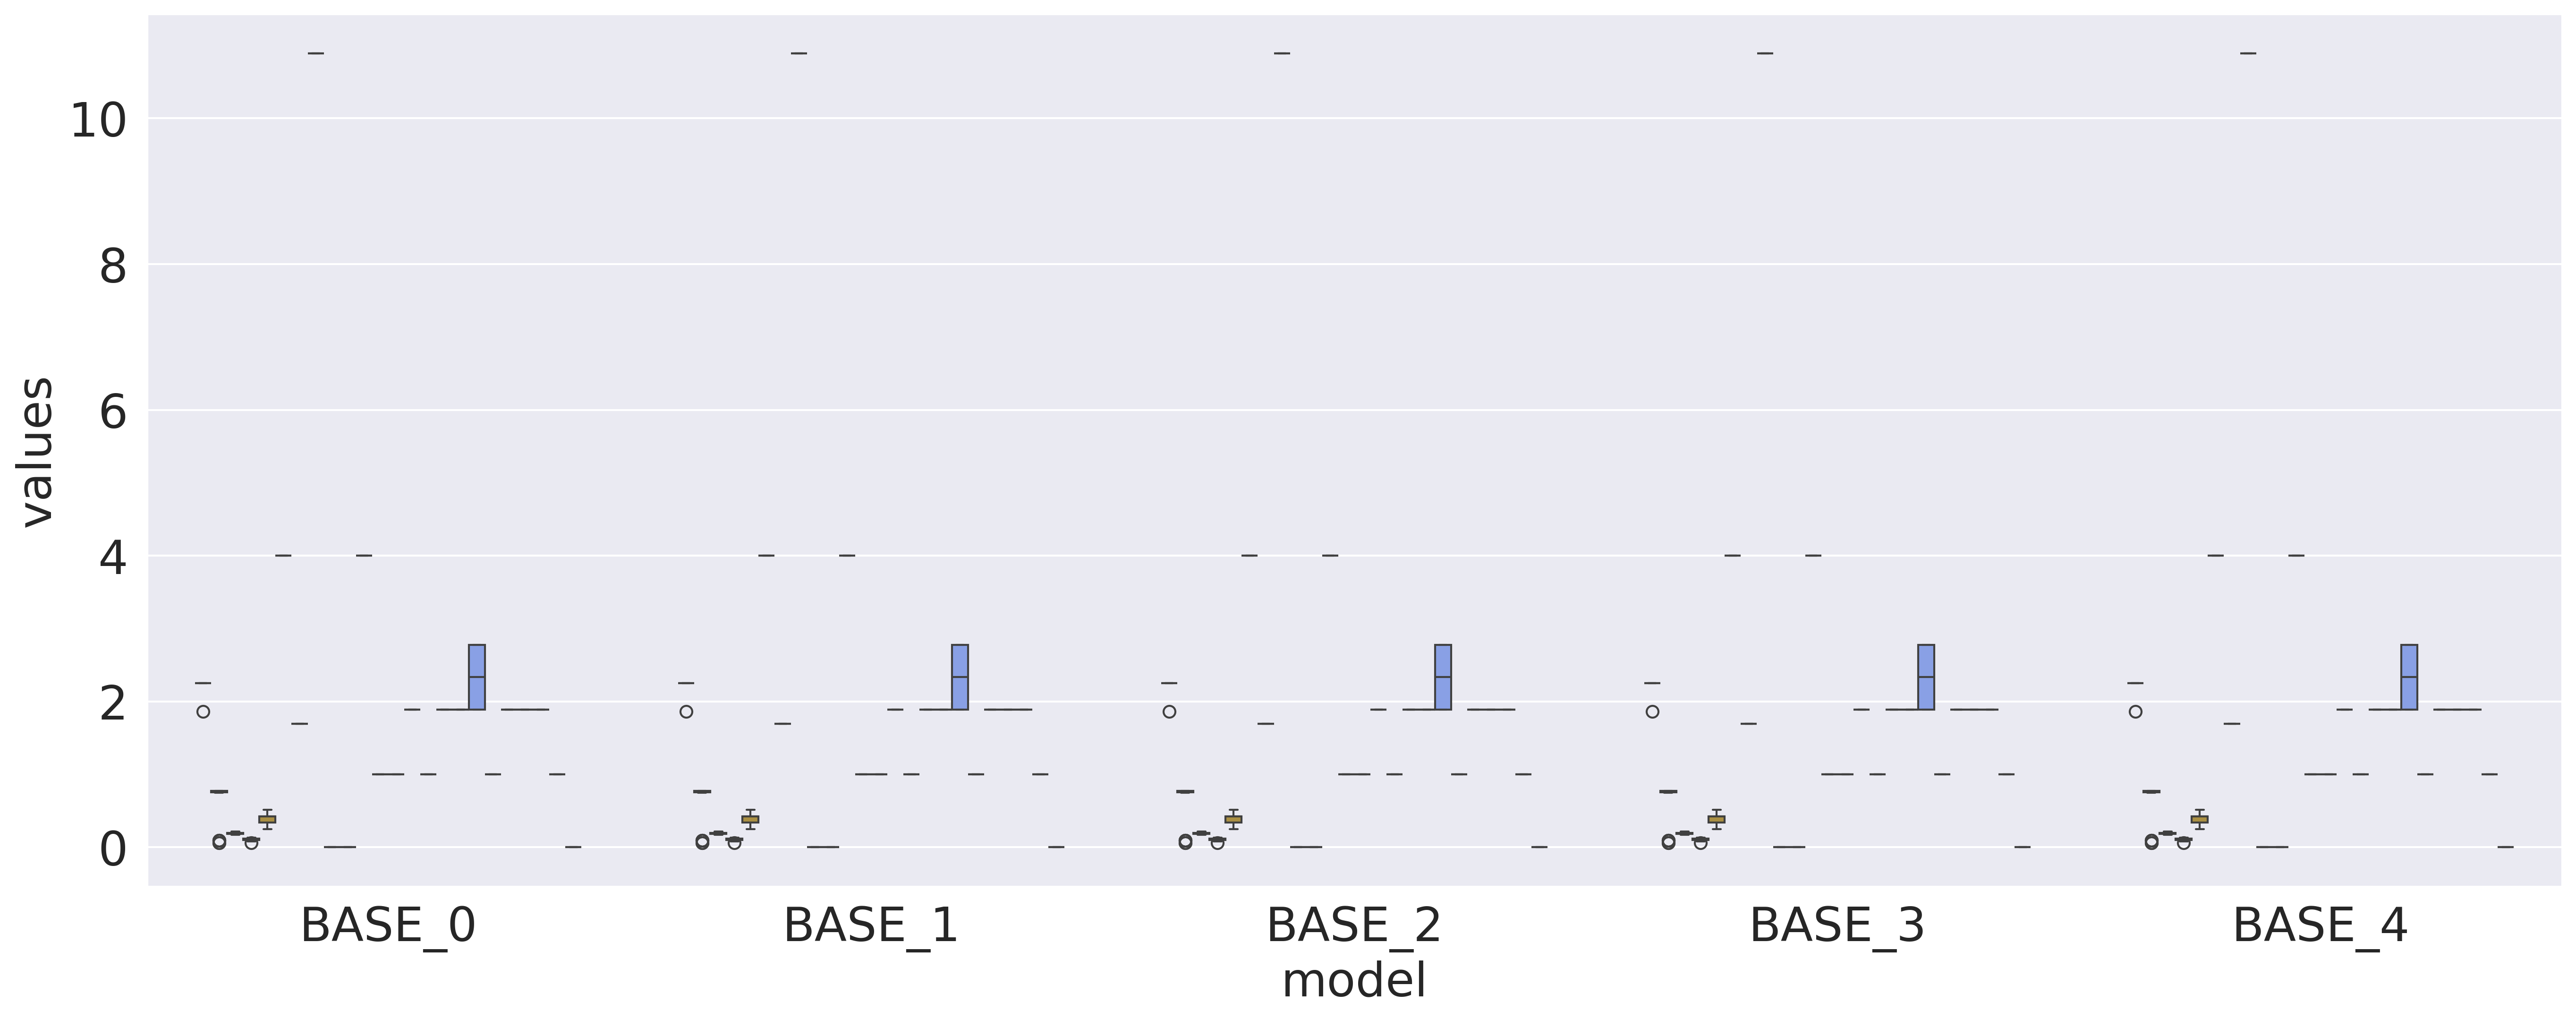

In [17]:
shm_scoring = SHM_Scoring()

fig = plot_metrics(extract_metrics(results, shm_scoring.REAL_MSE_RESULTS))
plt.gca().get_legend().remove()
plt.show()

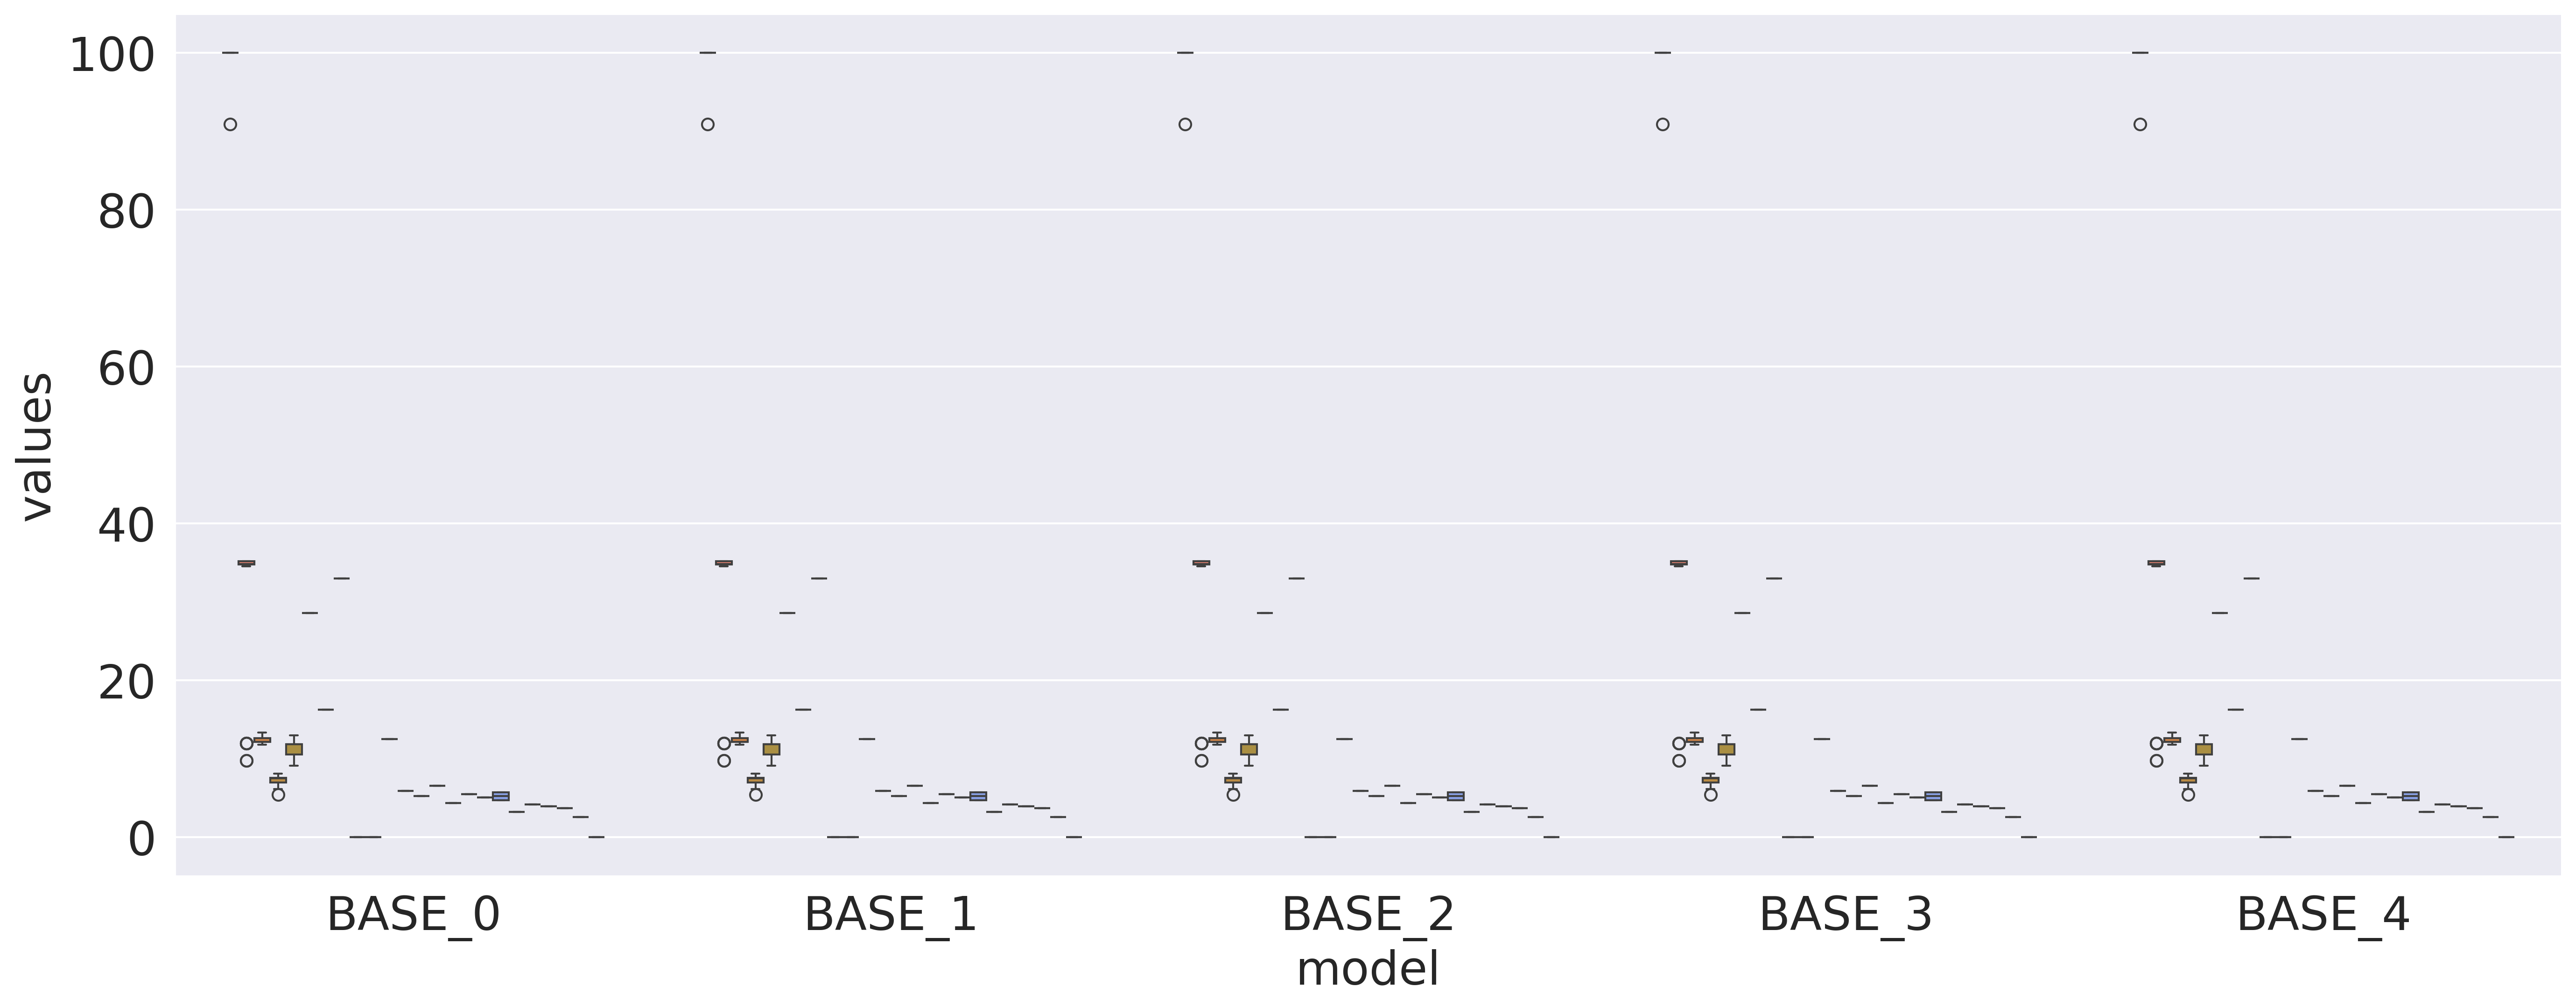

In [18]:
fig = plot_metrics(extract_metrics(results, shm_scoring.REAL_REL_ERROR))
plt.gca().get_legend().remove()
plt.show()

In [19]:
samples_per_class = 40
classes, counts = np.unique(ysyn, return_counts=True)
n_classes = len(classes)

strgy = dict(zip(range(n_classes), [samples_per_class] * n_classes))
sampler = ClusterCentroids(estimator=KMeans(n_init="auto", random_state=random_state), sampling_strategy=strgy, random_state=random_state)

estimator = KNeighborsRegressor(n_neighbors=1, leaf_size=1)

pipeline = build_sampled_pipeline(sampler, estimator)
pipeline.fit(Xsyn, ysyn)
y_pred = pipeline.predict(Xreal)
y_pred


array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  6.7,
       12. , 14. , 14. , 16. , 18. ,  2.2, 22. , 22. , 24. , 26. , 30. ,
        3.8, 30. , 34. , 36. , 38. , 40. ,  4.4, 40. ,  5. ,  5. ,  6.7,
        0. ,  6.7, 12. , 14. , 14. , 16. , 20. ,  2.5, 22. , 22. , 26. ,
       28. , 30. ,  4.1, 30. , 34. , 36. , 38. , 40. ,  4.4, 40. ,  5. ,
        5. ,  6.7,  0. ,  6.7, 12. , 14. , 14. , 16. , 20. ,  2.2, 22. ,
       24. , 26. , 28. , 30. ,  4.1, 32. , 34. , 36. , 38. , 40. ,  4.4,
       40. ,  5. ,  5. ,  6.7,  0. ,  6.7, 12. , 14. , 14. , 18. , 20. ,
        2.2, 24. , 24. , 28. , 30. , 32. ,  4.1, 32. , 36. , 38. , 40. ,
       40. ,  4.7, 40. ,  5. ,  5. ,  6.7,  0. ,  6.7, 12. , 14. , 14. ,
       16. , 18. ,  0. , 20. , 22. , 24. , 26. , 28. ,  3.8, 30. , 34. ,
       36. , 38. , 40. ,  4.1, 40. ,  5. ,  5. ,  6.7,  0. ,  6.7, 12. ,
       14. , 14. , 16. , 18. ,  2.2, 20. , 22. , 24. , 26. , 30. ,  3.8,
       30. , 34. , 36. , 38. , 40. ,  4.1, 40. ,  

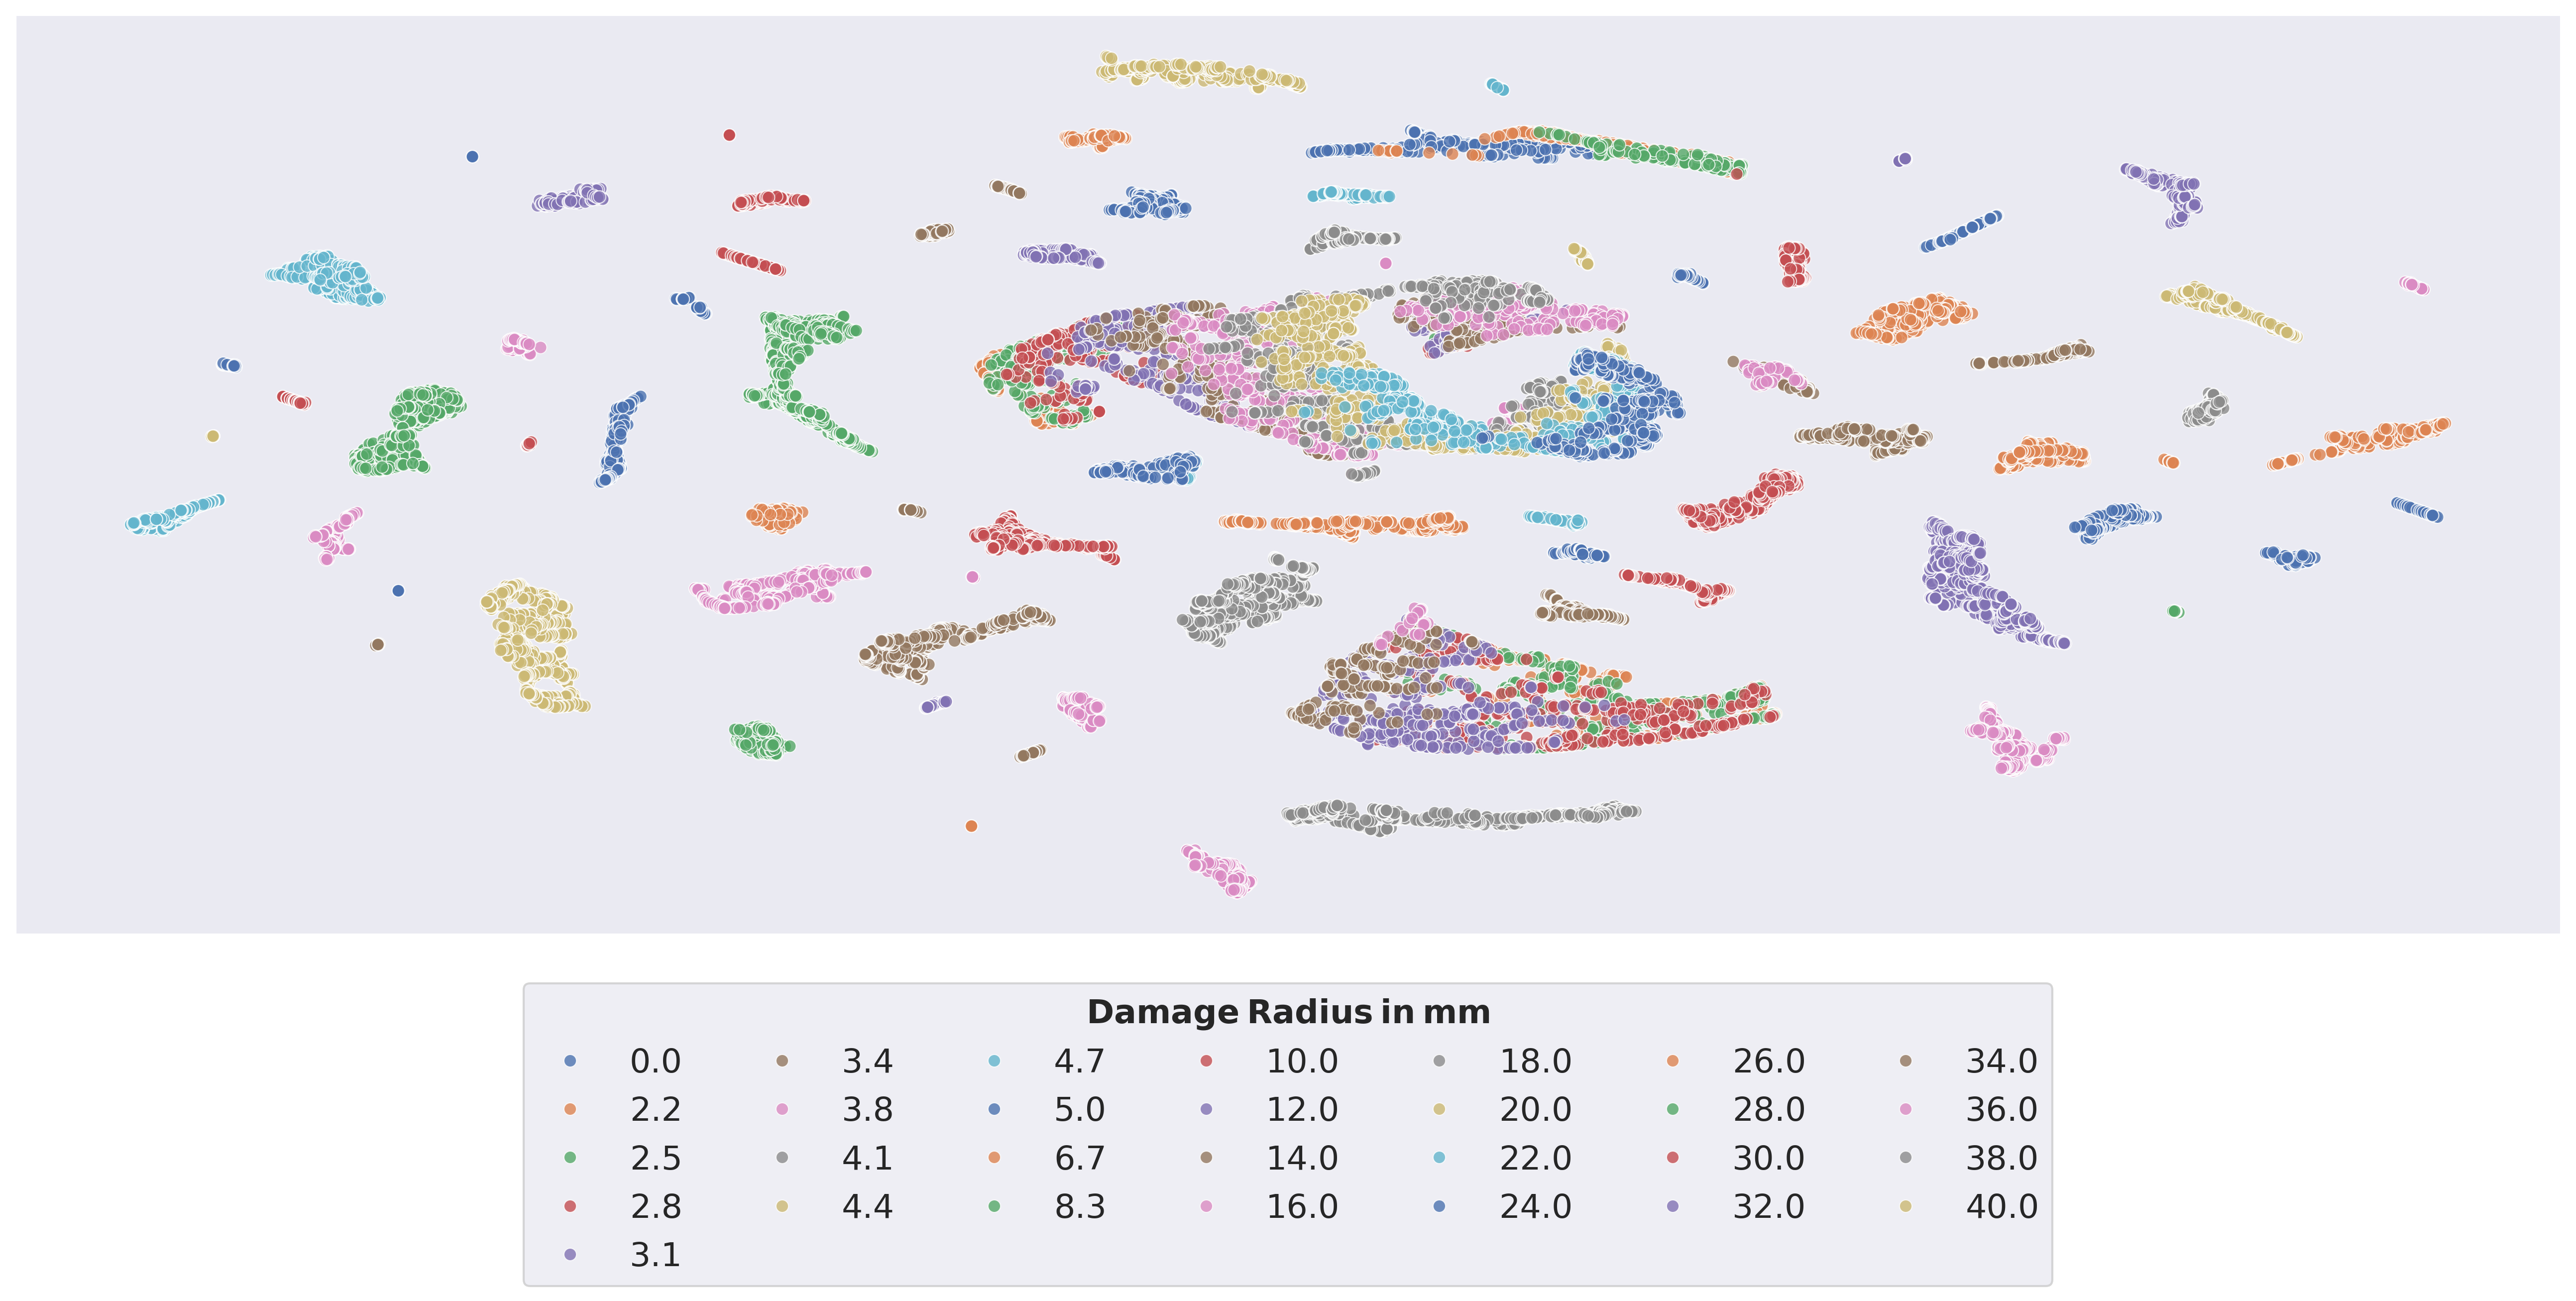

In [20]:
from manifold_utils import umap_embedding
umap, X_embedded = umap_embedding(X=Xsyn, n_neighbors=15)

palette = dict(zip(np.unique(ysyn), sns.color_palette(None, len(np.unique(ysyn)))))
fig = plot_embedding_targets(X_embedded, y=ysyn, alpha=0.8, palette=palette)

legend = plt.legend(ncol=7, loc="lower center", bbox_to_anchor=(0.5, -0.4), title_fontsize=16, fontsize=16)
legend.set_title("$\\bf{Damage\:Radius\:in\:mm}$")

plt.xticks([])
plt.yticks([]);

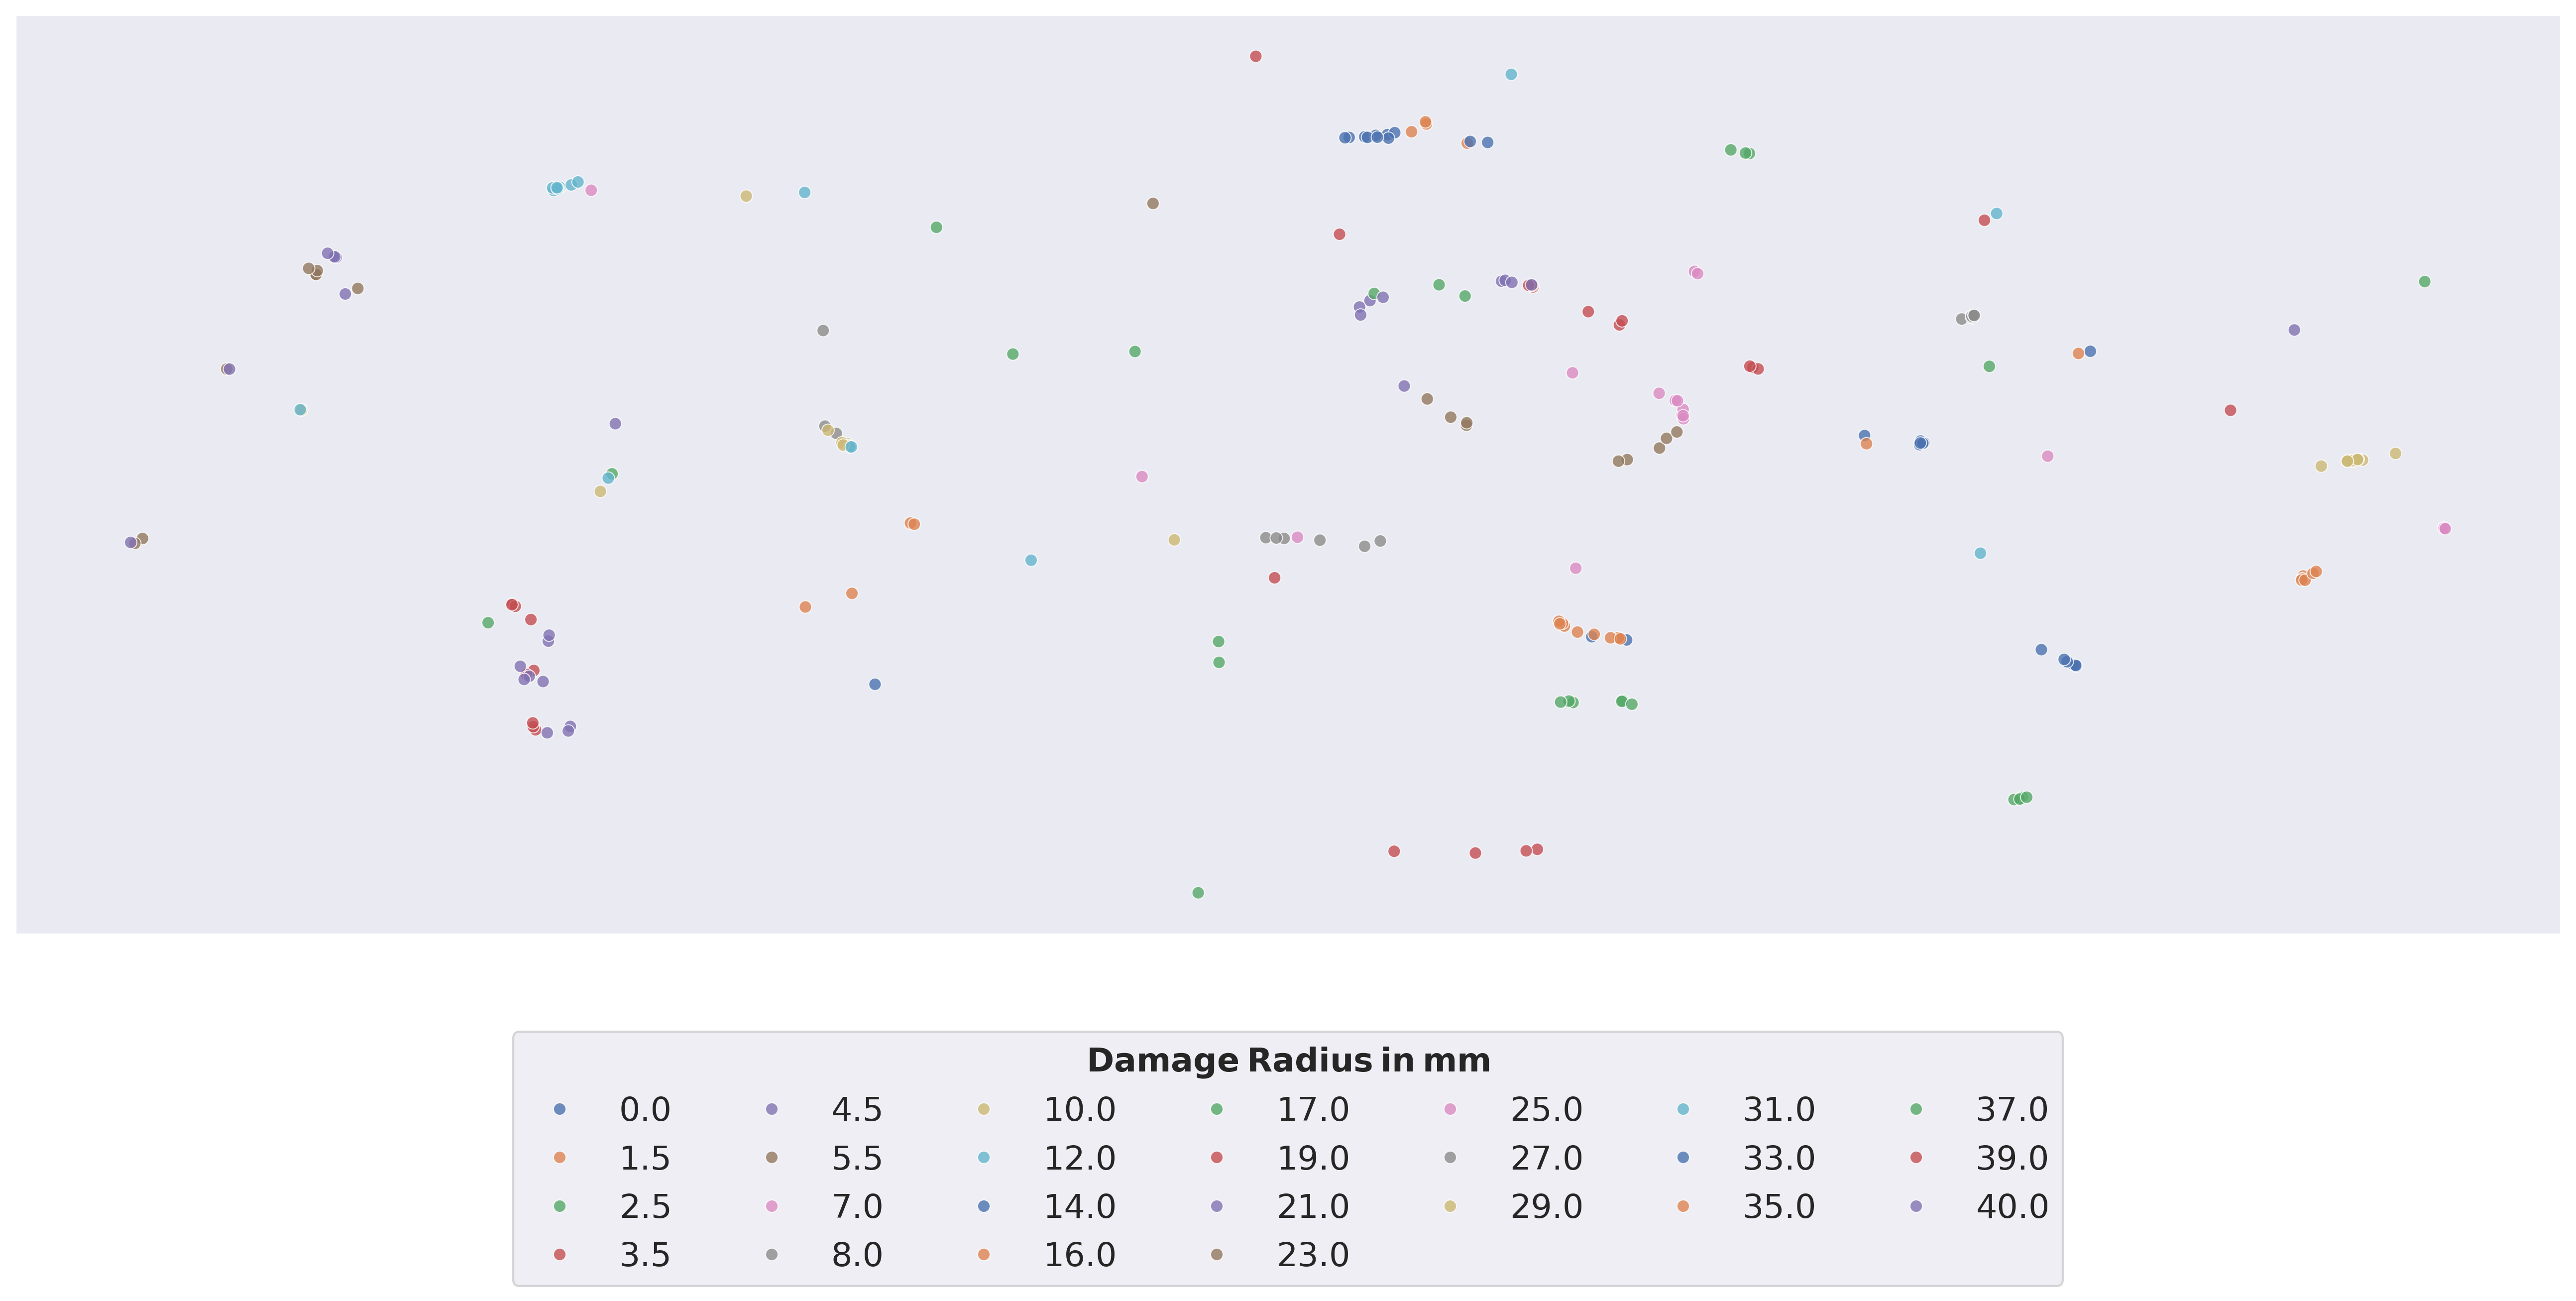

In [21]:
X_embedded = umap.transform(Xreal)

palette = dict(zip(np.unique(yreal), sns.color_palette(None, len(np.unique(yreal)))))
fig = plot_embedding_targets(X_embedded, y=yreal, alpha=0.8, palette=palette)

legend = plt.legend(ncol=7, loc="lower center", bbox_to_anchor=(0.5, -0.4), title_fontsize=16, fontsize=16)
legend.set_title("$\\bf{Damage\:Radius\:in\:mm}$")

plt.xticks([])
plt.yticks([]);

In [22]:
import plotly.graph_objects as go
import plotly.express as px

def plot_errors(feat_embedding, trg, pred):
    sc1 = px.scatter_3d(x=feat_embedding[..., 0], y=feat_embedding[..., 1], z=yreal, color=yreal/4, title="Target")
    sc2 = px.scatter_3d(x=feat_embedding[..., 0], y=feat_embedding[..., 1], z=y_pred, color=(yreal-y_pred)**2, title="Prediction")

    line_xy = np.repeat(feat_embedding, repeats=3, axis=0)
    line_xy[2::3] = None

    line_z = np.empty((3 * trg.shape[0], ))
    line_z[::3] = trg
    line_z[1::3] = pred
    line_z[2::3] = None

    sc3 = go.Scatter3d(x=line_xy[..., 0], y=line_xy[..., 1], z=line_z, mode="lines", marker_size=2)
    
    fig = go.Figure(data=sc1.data + sc2.data + (sc3, ))
    
    fig.data[1].marker.symbol = 'x'      
    fig.update_traces(marker_size=3, 
                      line=dict(color='purple',
                                width=5))
    fig.update_layout(
        autosize=False,
        width=1200,
        height=1200,)
    
    return fig

plot_errors(X_embedded, yreal, y_pred)

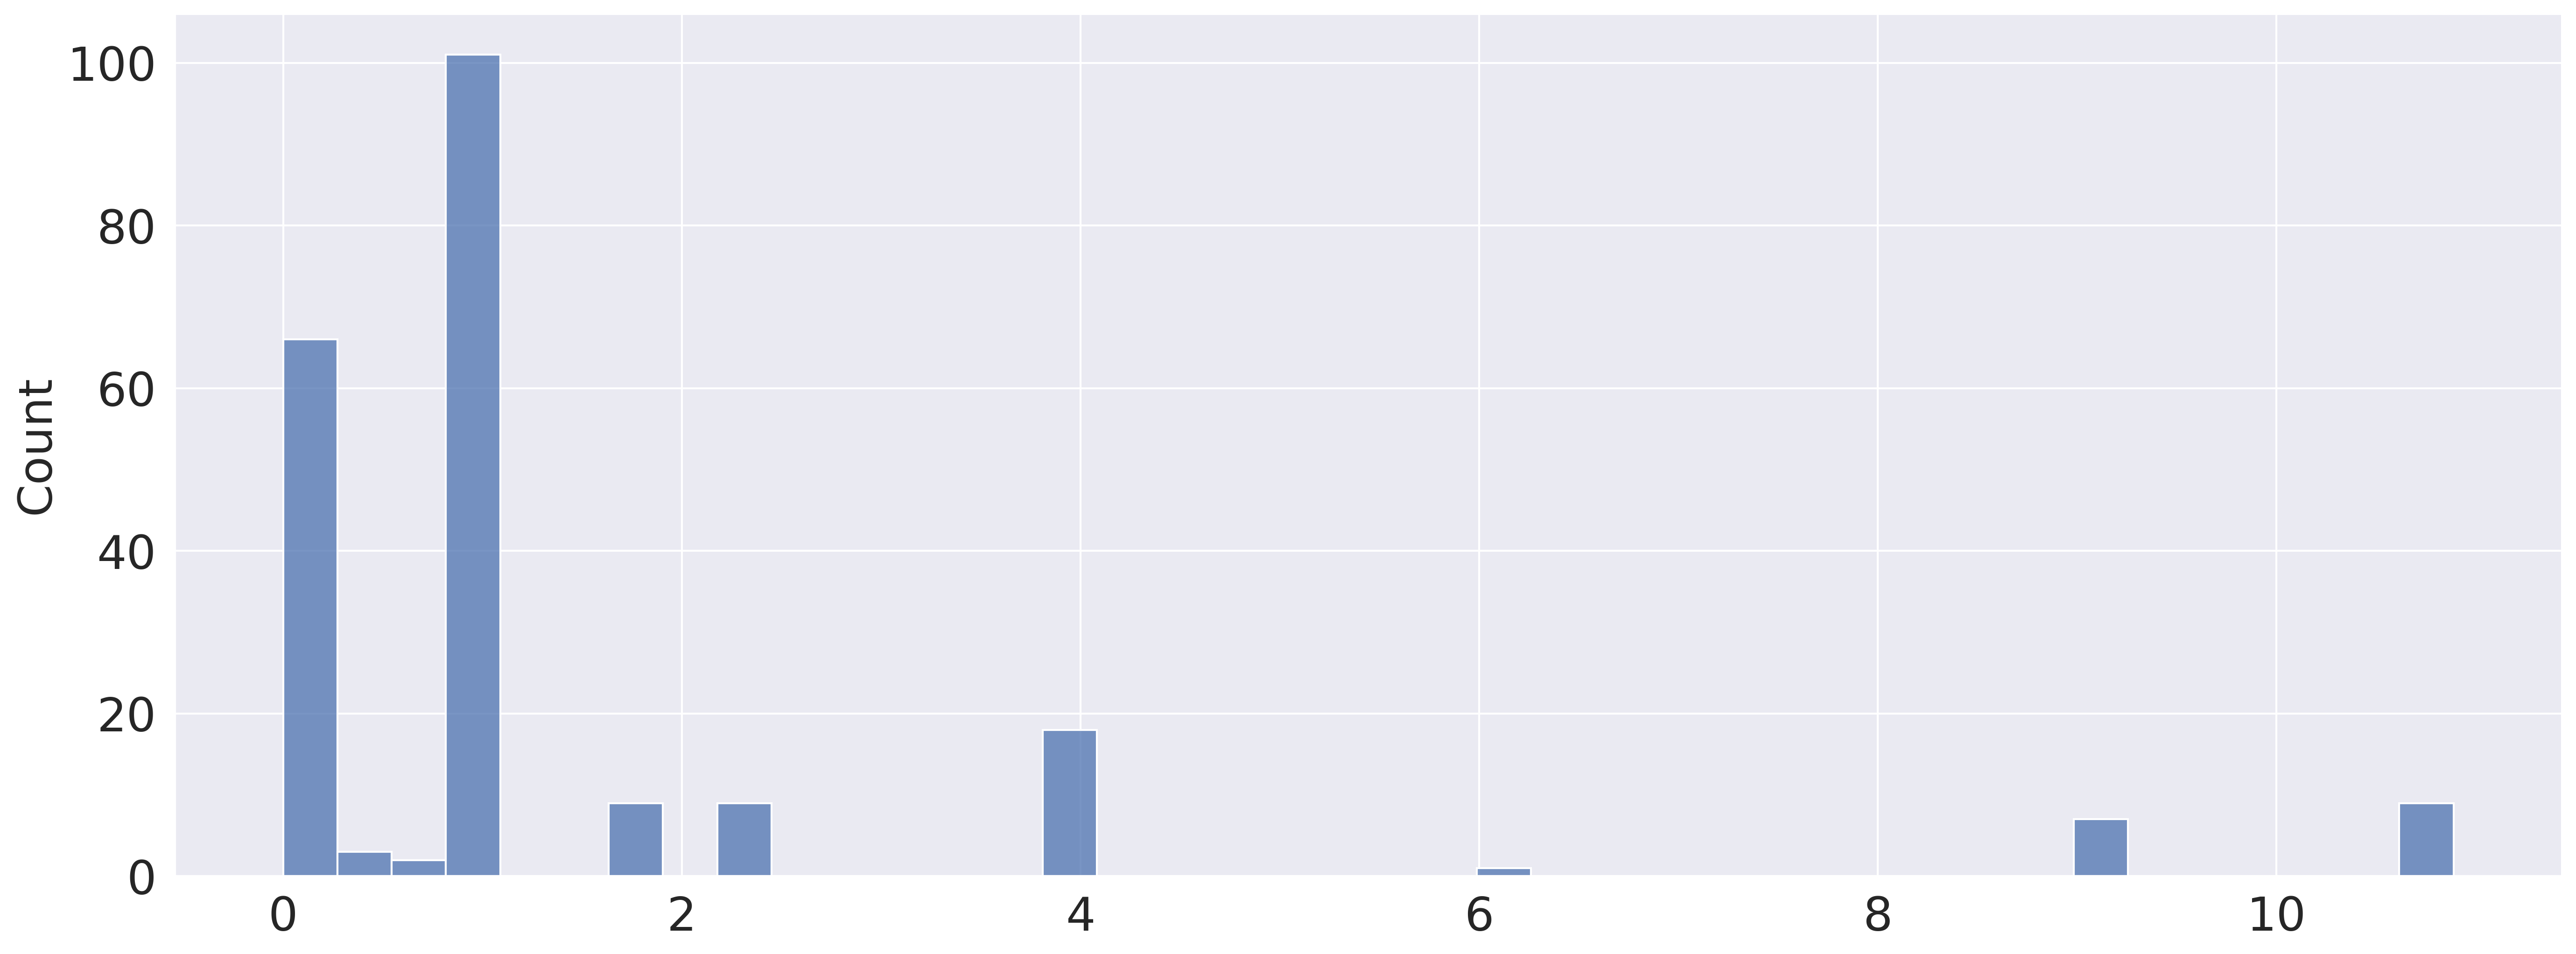

In [23]:
sns.histplot((yreal-y_pred)**2);

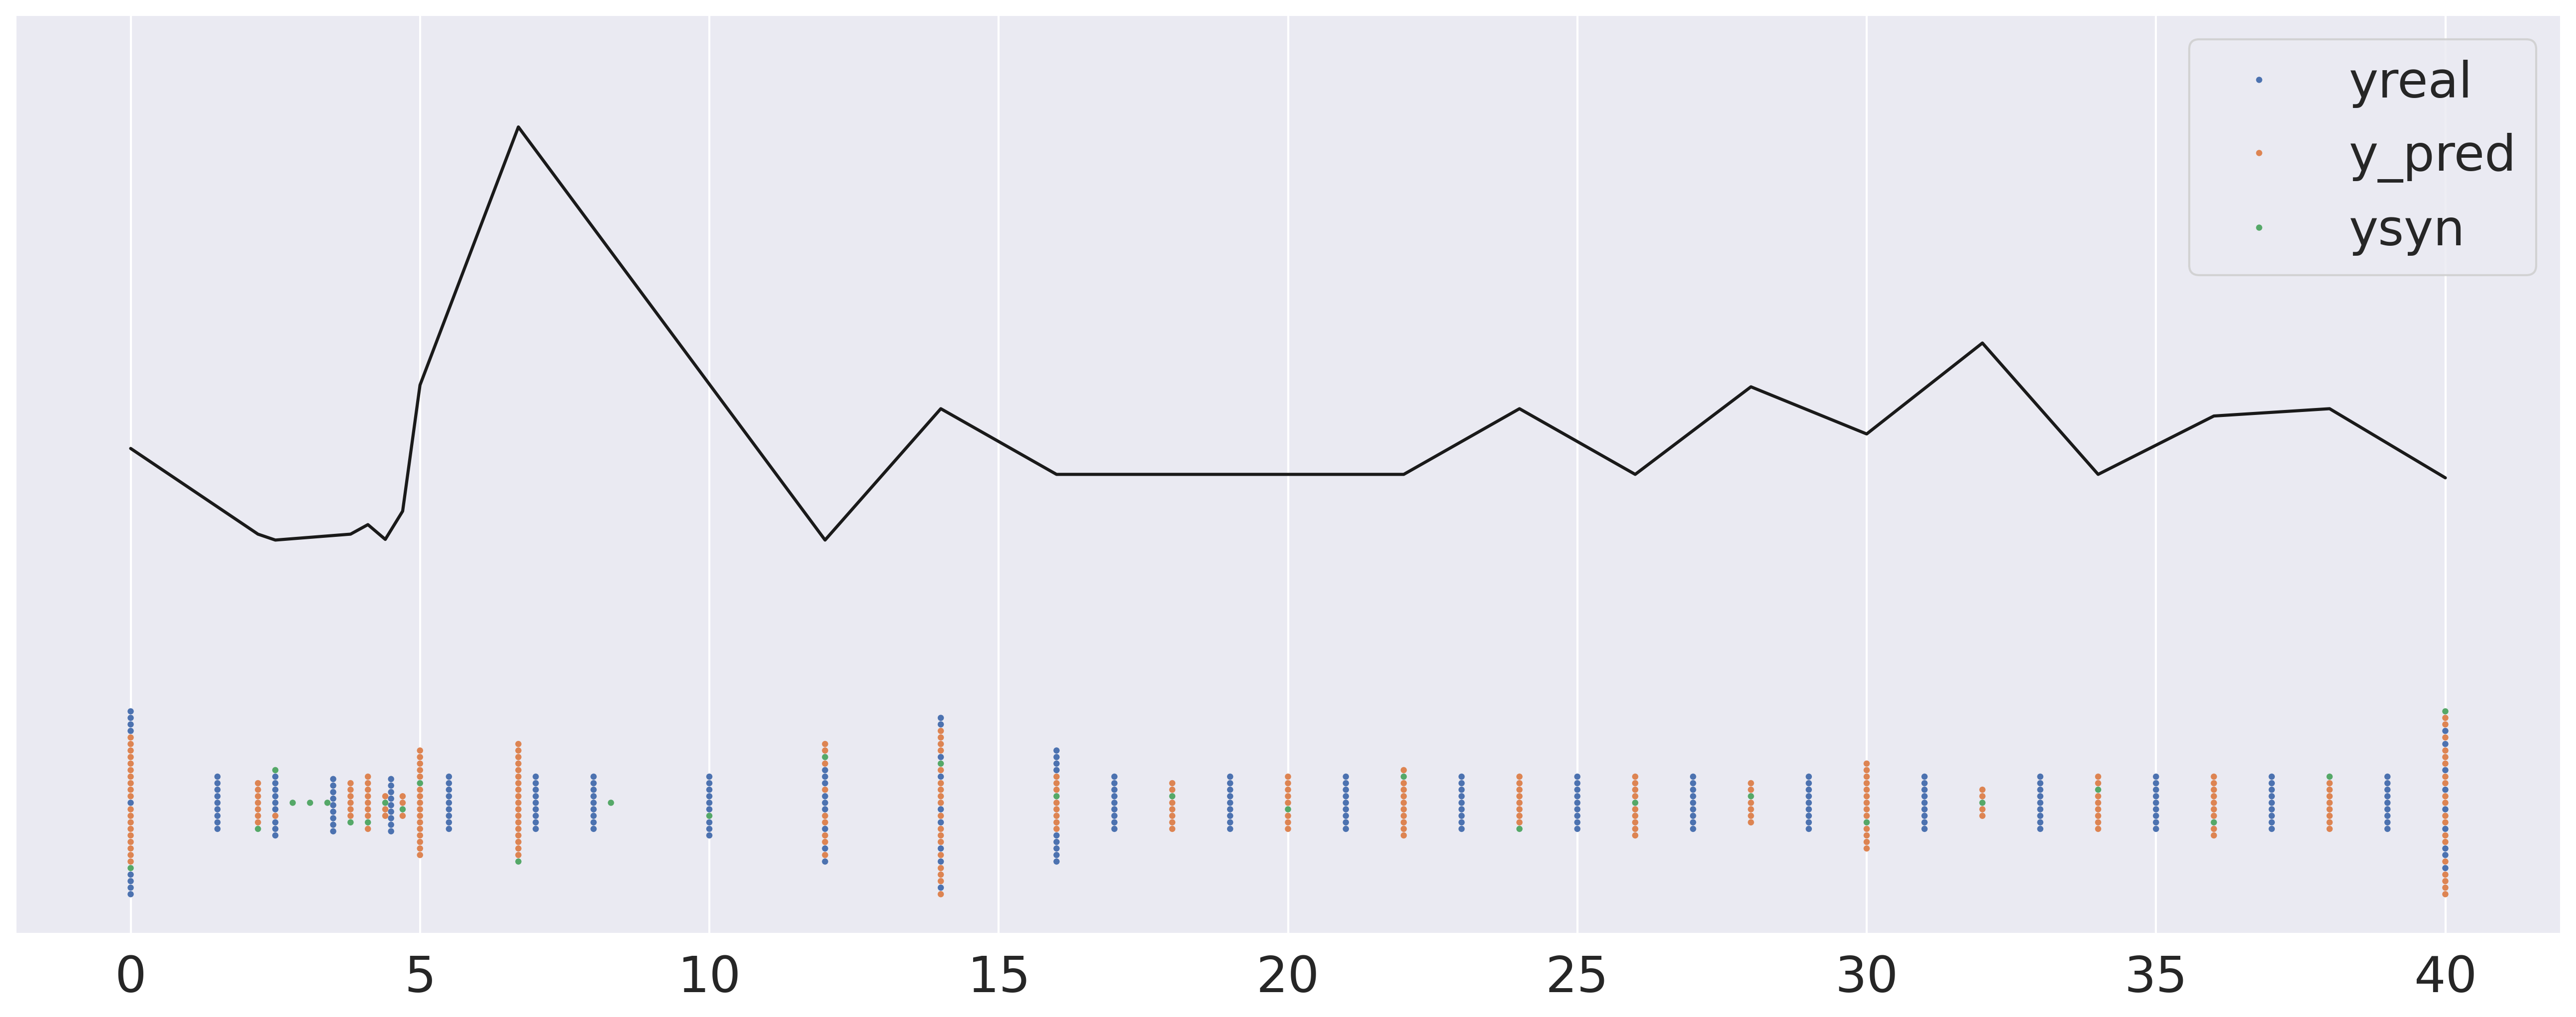

In [24]:
y_data = [((yreal[np.argwhere(np.abs(y_pred-l) < 0.01)] - y_pred[np.argwhere(np.abs(y_pred-l) < 0.01)])**2).mean() / 4 + 1 for l in np.unique(y_pred)]
sns.lineplot(x=np.unique(y_pred), y=y_data, color="k")

x_data = np.concatenate([yreal, y_pred, np.unique(ysyn)], axis=0)
h_data = ["yreal"] * len(yreal) + ["y_pred"] * len(y_pred) + ["ysyn"] * len(np.unique(ysyn))

ax = sns.swarmplot(x=x_data, orient="h", hue=h_data, size=3, alpha=1.)
ax.set_ylim([-0.5, 3]);

In [25]:
import plotly.graph_objects as go

def plot_sankey(src, trg, title=None, use_l2=False):
    l = 1
    if use_l2:
        l = 2
        
    ssrc = np.array([f"Label: {s}" for s in src])
    strg = np.array([f"Target: {t}" for t in trg])

    suniques = np.unique(src)
    tuniques = np.unique(trg)
    
    sdec = dict(enumerate(suniques))
    tdec = dict(enumerate(tuniques, start=len(sdec)))

    senc = {s: i for i, s in sdec.items()}
    tenc = {t: i for i, t in tdec.items()}

    labels = [f"Target: {s}" for s in suniques] + [f"Prediction: {t}" for t in tuniques]
    cidxes = np.concatenate([suniques, tuniques], axis=0).argsort().argsort()
    ncolors = px.colors.sample_colorscale("YlOrRd", [n/(len(cidxes) -1) for n in cidxes])
    
    links, counts = np.unique([(senc[s], tenc[t]) for s, t in zip(src, trg)], axis=0, return_counts=True)
    maxerr = np.abs((src - trg)**l).max()
    
    def get_color(s, t):
        err = np.abs(sdec[s] - tdec[t])**l
        p = err / maxerr

        red = 255 * p
        green = 255 * (1 - p)
        return f"rgba({red},{green},0,0.2)"

    lcolors = [get_color(s, t) for s, t in links]
    
    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",
        node = dict(
          pad = 15,
          thickness = 50,
          line = dict(color = "black", width = 0.5),
          label = labels,
          color=ncolors
        ),
        link = dict(
          source = links[:, 0],
          target = links[:, 1],
          value = counts,
          color=lcolors
      ))])
      
    fig.update_layout(title_text=title, font_size=20, width=1000, height=1000)
    return fig

plot_sankey(yreal, y_pred, "Prediction error analysis")